In [ ]:
#This code extends the following source code: 
#https://www.kaggle.com/delllectron/deep-learning-on-covid-19

#The two datasets this model uses can be found here:
#https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset
#https://github.com/ieee8023/covid-chestxray-dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#NOTE to TA: Type in your particular filepath here. Please be sure to access the Chest_xray_Corona_Metadata.csv file of the Corona-Hack dataset.
df = pd.read_csv('/content/drive/MyDrive/COVID Kaggle Data/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


###ADD SAMPLES FROM CORONA-HACK DATASET

In [ ]:
#Get the path of train and test folders. NOTE to TA: Type in your particular filepath here. Please be sure to access the train and test folders of the Corona-Hack dataset.
train_img_path_one = '/content/drive/MyDrive/COVID Kaggle Data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_img_path_one = '/content/drive/MyDrive/COVID Kaggle Data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

In [ ]:
#Separate pre-set train and test data into respective DataFrames.
train_data = df[df['Dataset_type']=='TRAIN']
test_data = df[df['Dataset_type']=='TEST']

In [ ]:
#Remove pneumonia with unknown value (i.e. unknown diagnosis of COVID-19). Our classification task only 
#compares a patient with COVID-19 and a completely healthy patient. Other kinds of pneumonias are not taken
#into consideration.
train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]
test_data = test_data[(test_data['Label'] == 'Normal') | 
                              ((test_data['Label'] == 'Pnemonia') &
                               (test_data['Label_2_Virus_category'] == 'COVID-19'))]

In [ ]:
#Fill in all null entries of Label_2_Virus_category as "N/A" as in "Not Applicable". 
#All such records are healthy patients, and thus do not have a corresponding entry for Label_2_Virus_category. 
train_data.fillna('N/A', inplace=True)
train_data.isnull().sum()

test_data.fillna('N/A', inplace=True)
test_data.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [ ]:
#Add a target and class feature.
train_data['class'] = train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

train_data['target'] = train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

In [ ]:
#Get the important features.
train_data = train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
test_data = test_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]

In [ ]:
print(train_data['class'].value_counts())
print() #Print a new line. 
print(test_data['class'].value_counts())

#It is clear that the test set has no COVID images, and that there is a very small number of such images generally. This is seen in the print below.

negative    1342
positive      58
Name: class, dtype: int64

negative    234
Name: class, dtype: int64


In [ ]:
#Function to convert image to array.
def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    #Convert image to array.
    img = image.img_to_array(img) / 255
    return img

In [ ]:
#Extract the image from training data and test data, then convert it to an array.
train_arrays = [] 
train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (224,224), train_img_path_one)))
test_arrays = []
test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (224,224), test_img_path_one)))

In [ ]:
#Take final_train_data and final_test_data and combine into single dataset.
x_dataset = np.concatenate((np.asarray(train_arrays), np.asarray(test_arrays)))
y_dataset = np.concatenate((train_data['target'].values, test_data['target'].values))

#Verify that the lengths of x_dataset and y_dataset are equivalent.
print(len(x_dataset))
print(len(y_dataset))

#The dataset is extremely imbalanced. Based on the excel sheet, there are only 58 COVID samples. Thus, COVID samples from an alternate dataset are added as well.

1634
1634


###ADD COVID SAMPLES FROM DR. COHEN'S DATASET

In [ ]:
#Load in the metadata.csv file of Dr. Cohen's COVID image collection. NOTE to TA: Type in your particular filepath here. 
df = pd.read_csv('/content/drive/MyDrive/covid-chestxray-dataset/metadata.csv')

#Get the relevant features of the dataset.
more_x_data = df[['finding', 'filename', 'modality']]

new_data_arrays = []
new_y_data_arrays = []

#Load in the data. Only load COVID samples.
img_path_two = '/content/drive/MyDrive/covid-chestxray-dataset/images'
for i in range(len(more_x_data)):
  if ((more_x_data.iloc[i]['finding'] == 'Pneumonia/Viral/COVID-19') and (more_x_data.iloc[i]['modality'] == 'X-ray')):
    new_data_arrays.append(read_img(more_x_data.iloc[i]['filename'], (224,224), img_path_two))
    new_y_data_arrays.append(1)
  

In [ ]:
#Concatenate this dataset with existing dataset. Concatenate new inputs with existing inputs, and new targets with existing targets.
x_dataset = np.concatenate((x_dataset, np.asarray(new_data_arrays)))
y_dataset = np.concatenate((y_dataset, np.asarray(new_y_data_arrays)))

#Print the number of COVID samples. We notice that there are only 562 COVID samples out of a total dataset of 2138.
print(np.count_nonzero(y_dataset == 1))
print(len(y_dataset))

562
2138


### ADD MORE COVID SAMPLES WITH DATA AUGMENTATION

In [ ]:
#Create a imagegenerator for for augmentation.
datagen = ImageDataGenerator(
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  horizontal_flip = True,
  shear_range=0.2,
  zoom_range=0.2
)

#Augment the images labeled with covid-19 to balance the data.
with_corona_augmented = []

for i in range(len(x_dataset)):
  #Only consider a COVID sample, as that is what is being augmented. 
  if y_dataset[i] == 1:
    x = x_dataset[i].reshape((1,) + x_dataset[i].shape)
    for batch in datagen.flow(x, batch_size = 4):
      with_corona_augmented.append(batch)
      i = i+1
      if i > 20:
        break


In [ ]:
#Remove extra dimension from with_corona_augmented.
with_corona_augmented = np.asarray(with_corona_augmented).squeeze()

#Verify that the input shape of a sample image is (224, 224, 3).
print(np.asarray(with_corona_augmented)[0].shape)

(224, 224, 3)


In [ ]:
#Concatenate the datasets.
x_dataset = np.concatenate((x_dataset, with_corona_augmented))
y_dataset = np.concatenate((y_dataset, np.ones(len(with_corona_augmented))))

In [ ]:
#Print the number of COVID samples. We notice that there are only 1124 COVID samples out of a total dataset of 2700.
#This is sufficient.
print(np.count_nonzero(y_dataset == 1))
print(len(y_dataset))

1124
2700


###SEPARATE FINAL DATASET INTO TRAINING AND TEST SET

In [ ]:
#Separate train data and test data.
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(x_dataset, y_dataset, test_size = 0.3)

### CONVERT ALL THE DATA TO TENSORS

In [ ]:
train_tensors = tf.convert_to_tensor(trainX)
test_tensors  = tf.convert_to_tensor(testX)
y_train_tensor = tf.convert_to_tensor(trainY)
y_test_tensor = tf.convert_to_tensor(testY)

### CREATE A TENSOR DATASET

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

### GENERATE BATCHES

In [ ]:
BATCH_SIZE = 16
BUFFER = 1000

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

for i,l in train_batches.take(1):
    print('Train Shape per Batch: ',i.shape);
for i,l in test_batches.take(1):
    print('Test Shape per Batch: ',i.shape);

Train Shape per Batch:  (16, 224, 224, 3)
Test Shape per Batch:  (16, 224, 224, 3)



### ATTEMPT OF POSSIBLE WAYS TO EXTEND SOURCE CODE
The following cell uses the `kerastuner` library to explore good parameter values for a dense layer. It is clear from the printed results that 128 is a strong value. This is the same as the original value.


Final extension of source code below.

In [ ]:
from tensorflow import keras

INPUT_SHAPE = (224,224,3) 

#Get the pretrained model.
base_model = tf.keras.applications.NASNetMobile(input_shape= INPUT_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

for layer in base_model.layers:
  if layer.name == 'separable_conv_2_bn_normal_left':
    break
  layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(Layers.GlobalAveragePooling2D())
model.add(Layers.Dense(192))
model.add(Layers.Dropout(0.23))
model.add(Layers.Dense(112))
model.add(Layers.Dropout(0.2))

model.add(Layers.Dense(64))
model.add(Layers.Dropout(0.2))

model.add(Layers.Dense(32))
model.add(Layers.Dropout(0.2))

model.add(Layers.Dense(16))
model.add(Layers.Dropout(0.2))

model.add(Layers.Dense(16))
model.add(Layers.Dropout(0.2))

model.add(Layers.Dense(1, activation = 'sigmoid'))

learning_rate = 0.005
decay_rate = learning_rate / epochs

model.compile(keras.optimizers.Adam(learning_rate=learning_rate,
                                                decay = (0.005/10)),
            loss = 'binary_crossentropy',
            metrics = [keras.metrics.AUC(name='auc'), 'accuracy'])


history = model.fit(train_batches, epochs=3, validation_data=test_batches)



Epoch 1/3
119/119 [==============================] - 12s 100ms/step - loss: 1.0890 - auc: 0.9483 - accuracy: 0.9339 - val_loss: 0.7826 - val_auc: 0.9816 - val_accuracy: 0.9802
Epoch 2/3
119/119 [==============================] - 8s 68ms/step - loss: 0.8635 - auc: 0.9711 - accuracy: 0.9630 - val_loss: 0.3737 - val_auc: 0.9877 - val_accuracy: 0.9852
Epoch 3/3
119/119 [==============================] - 8s 69ms/step - loss: 0.3613 - auc: 0.9836 - accuracy: 0.9783 - val_loss: 0.0736 - val_auc: 0.9953 - val_accuracy: 0.9914


In [ ]:
#Plotting the evaluation metrics
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['auc'],
                         line=dict(color='firebrick', width=2, dash='dash'), name='AUC'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_auc'],
                         line=dict(color='turquoise', width=2), name='validation AUC'))

fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'],
                         line=dict(color='orange', width=2, dash='dash'), name='accuracy'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'],
                         line=dict(color='green', width=2), name='validation accuracy'))

fig.update_layout(title_text='Evaluation Metrics', font_size=15, xaxis_title='Epochs')
fig.show()

In [ ]:
#Predict the test data.
pred = model.predict_classes(test_tensors)

#Convert actual labels and predicted labels to numpy arrays.
actLabels = y_test_tensor.numpy()
predLabels = np.asarray(pred).squeeze()


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
#Print a classification report.
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(actLabels, predLabels))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       458
         1.0       0.98      1.00      0.99       352

    accuracy                           0.99       810
   macro avg       0.99      0.99      0.99       810
weighted avg       0.99      0.99      0.99       810



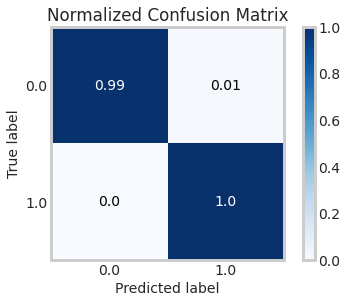

In [ ]:
#Print normalized confusion matrix.
!pip install scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(actLabels, predLabels, normalize=True)

In [ ]:
import sklearn

#Print regular confusion matrix.
data = {'yActual': actLabels, 'yPredicted': predLabels}
df = pd.DataFrame(data, columns=['yActual','yPredicted'])
confusionMatrix = pd.crosstab(df['yActual'], df['yPredicted'], rownames=['Actual'], colnames=['Predicted'])
print(confusionMatrix)

Predicted    0    1
Actual             
0.0        452    6
1.0          1  351
